Problem Formulation and Data Overview
The problem involves analyzing a dataset of terminal market prices for pumpkin crops some cities.  The objective is to answer specific questions related to the impact of factors like origin, quality, appearance, and seasonal trends on pricing. Additionally, the aim is to develop models for forecasting pumpkin prices in specific cities or regions based on historical data. Addressing these questions will provide valuable insights for farmers, distributors, and retailers to make informed decisions about pricing, supply chain management, and marketing strategies in the pumpkin market.The dataset contains information about pumpkin prices in 13 cities in the United States from September 24, 2016, to September 30, 2017. It includes details about the pumpkin's commodity name, city where it was sold, type, package, variety, sub-variety, grade, date of sale, low and high prices, mostly low and high prices, origin of the pumpkins, origin district, item size, color, environment, unit of sale, quality, condition, appearance, storage, crop, and whether the pumpkin has been repackaged before sale. The dataset aims to provide insights into the pricing and characteristics of pumpkins sold in different cities across the US.

# Packages and Data

In [76]:
#Import libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Hide warnings returned by cross validation.
import warnings
warnings.filterwarnings('ignore')

#Request URL for dataset
import urllib.request


In [77]:
#Loading Data
data_path = 'https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/2-Regression/data/US-pumpkins.csv'


def pumpkins(path):
    
    data_path = urllib.request.urlretrieve(path)[0]
    pumpkins = pd.read_csv((data_path), on_bad_lines='skip')
    
    return pumpkins

In [78]:
USpumpkins = pumpkins(data_path)
USpumpkins.shape

(1757, 26)

In [79]:
USpumpkins.head(5)

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


# Data preprocessing

In [80]:
# Checking missing values
USpumpkins.isnull().sum()

City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
dtype: int64

# Feature Engineering

In [81]:
#Adding a new column 
avg_price = (USpumpkins['Low Price'] + USpumpkins['High Price'] / 2 )
USpumpkins['Price'] = avg_price
USpumpkins.head(5)

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25,Price
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,410.0
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,410.0
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,240.0
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,240.0
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,140.0


In [82]:
#fiter 'packages' column
new_pumpkins = USpumpkins[USpumpkins['Package'].str.contains('bushel', case = True, regex = True)]
new_pumpkins.shape

(415, 27)

In [83]:
#Select packages with 1 1/9 and 1/2
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = avg_price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = avg_price*2

new_pumpkins.shape

(415, 27)

In [84]:
#Selecting columns
columns = ['Date', 'Package', 'Variety', 'Origin','City Name','Low Price', 'High Price', 'Price']
new_pumpkinsData = new_pumpkins.loc[:, columns]
new_pumpkinsData.head(5)

,Date,Package,Variety,Origin,City Name,Low Price,High Price,Price
70,9/24/16,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,15.0,15.0,20.454545
71,9/24/16,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,18.0,18.0,24.545455
72,10/1/16,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,18.0,18.0,24.545455
73,10/1/16,1 1/9 bushel cartons,PIE TYPE,OHIO,BALTIMORE,17.0,17.0,23.181818
74,10/8/16,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,15.0,15.0,20.454545


In [85]:
#Getting date in month of the year
month = pd.DatetimeIndex(new_pumpkinsData['Date']).month
new_pumpkinsData['Date'] = month
new_pumpkinsData.head(5)

,Date,Package,Variety,Origin,City Name,Low Price,High Price,Price
70,9,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,15.0,15.0,20.454545
71,9,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,18.0,18.0,24.545455
72,10,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,18.0,18.0,24.545455
73,10,1 1/9 bushel cartons,PIE TYPE,OHIO,BALTIMORE,17.0,17.0,23.181818
74,10,1 1/9 bushel cartons,PIE TYPE,DELAWARE,BALTIMORE,15.0,15.0,20.454545


In [86]:
# Categorical features
USpumpkinsData = new_pumpkinsData.drop(columns = "Price",axis = 0)
USpumpkinsData_labels = new_pumpkinsData["Price"]
cat_feats = new_pumpkinsData[['Variety', 'Package','Origin','City Name']]
num_feats = new_pumpkinsData[['Date', 'Low Price', 'High Price']]

# Filling missing values
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())

  ])
num_preprocessed = num_pipe.fit_transform(num_feats)

In [87]:
#Handling categorical features
# The transformer requires lists of features
num_list = list(num_feats)
cat_list = list(cat_feats)

num_cat_list = (zip(num_list,cat_list))
USpumpkinsData = np.array(num_cat_list)


final_pipe = ColumnTransformer([
     ('num', num_pipe, num_list),
     ('cat', OneHotEncoder(), cat_list)
])
USpumpkinsData_preprocessed = final_pipe.fit_transform(new_pumpkinsData)

In [88]:
USpumpkinsData_preprocessed

<415x36 sparse matrix of type '<class 'numpy.float64'>'
	with 2905 stored elements in Compressed Sparse Row format>

# Exploratory data analysis

-0.1475255281297151
                Date  Low Price  High Price
Date        1.000000  -0.021437   -0.045517
Low Price  -0.021437   1.000000    0.839121
High Price -0.045517   0.839121    1.000000


<Axes: >

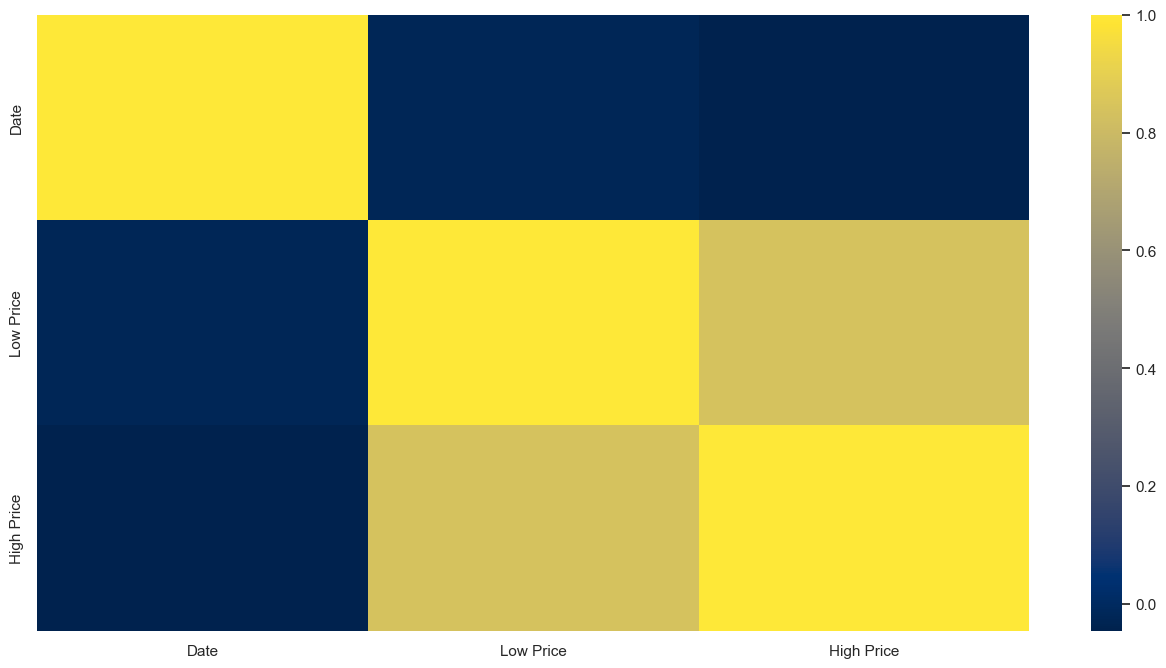

In [89]:
#finding correlation
print(new_pumpkinsData['Date'].corr(new_pumpkinsData['Price']))

corr_matrix = num_feats.corr(method='spearman')
print(corr_matrix)

sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(corr_matrix, cmap='cividis')

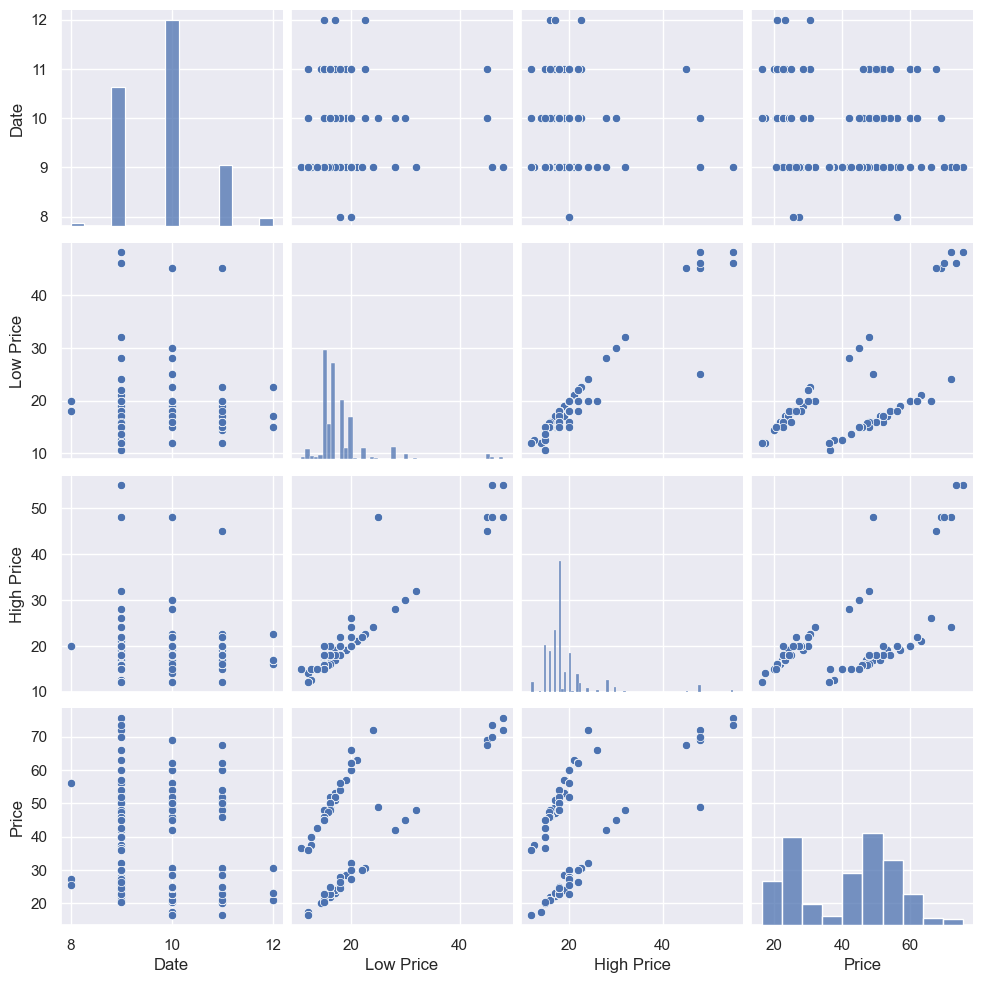

In [90]:
sns.pairplot(new_pumpkinsData)

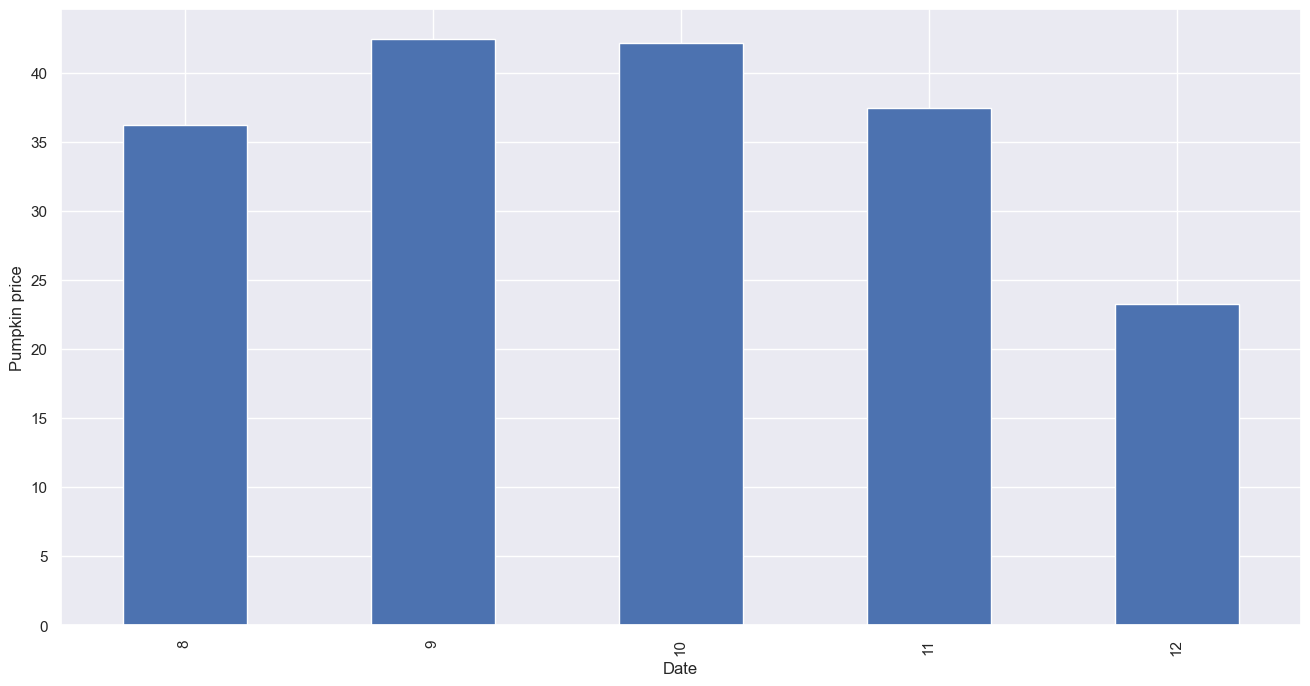

In [91]:
new_pumpkinsData.groupby(['Date'])['Price'].mean().plot(kind ='bar')
plt.xlabel("Date")
plt.ylabel("Pumpkin price")
plt.show()

Text(0.5, 1.0, 'Purchases Per Month')

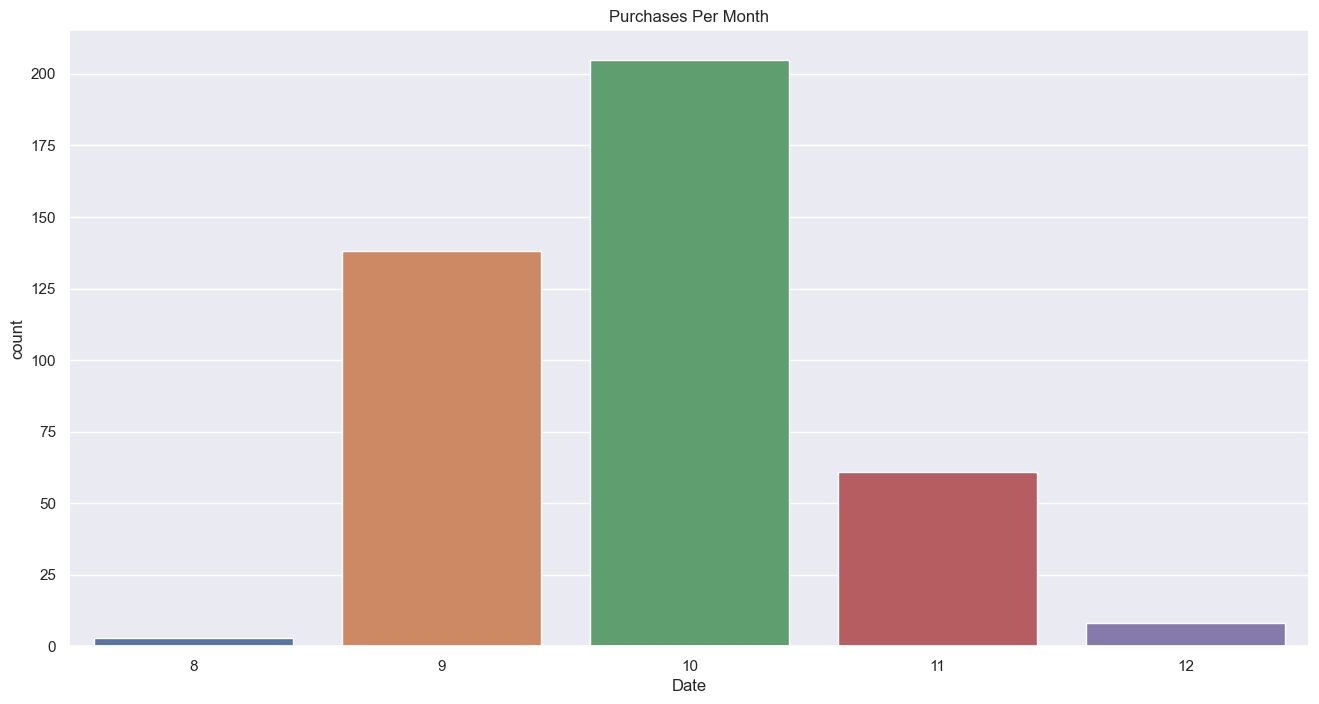

In [92]:
sns.countplot(x = new_pumpkinsData['Date'])
plt.title('Purchases Per Month')

# Features selection

In [93]:

X = pd.get_dummies(new_pumpkinsData['Variety']) \
        .join(new_pumpkinsData['Date']) \
        .join(pd.get_dummies(new_pumpkinsData['City Name'])) \
        .join(pd.get_dummies(new_pumpkinsData['Package']))
y = new_pumpkinsData['Price']

#Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model training and Evaluation

In [94]:
# Linear Regressor
#Training model: define the LinearRegression object, and fit it to data
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Evaluating model
#predict prices on a test dataset
y_pred = lin_reg.predict(X_test)

# print the intercept
print(f'Intercept: {lin_reg.intercept_}')

#measure accuracy of predictions
mse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(y_pred)*100:3.3}%)')

#check model quality using coefficient of determination
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

r2 = r2_score(y_test,y_pred)
print('r2 score for linear regression model is', r2)

Intercept: -21941334007140.477
Mean error: 4.52 (11.3%)
Model determination:  0.9383838937051775
r2 score for linear regression model is 0.9188491682367753


In [95]:
# Regressors Pipeline
#Build and train model
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())


pipeline.fit(X_train,y_train)

#predict prices on a test dataset
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean error: {mse:3.3} ({mse/np.mean(y_pred)*100:3.3}%)')

#check model quality using coefficient of determination
score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

r2 = r2_score(y_test,y_pred)
print('r2 score for polynomial regression model is', r2)

Mean error: 16.1 (39.6%)
Model determination:  0.9547509635082192
r2 score for polynomial regression model is 0.9361759940340928
